In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/heart-diseae/heart-disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


<font size="6">There are no missing values and all data types are integers (or float). Therefore, dataframe is ready for modeling and visualization.</font>

# **1- Data Visualization**

<font size="6">First, a pairplot of the dataset was generated to review all the values.</font>

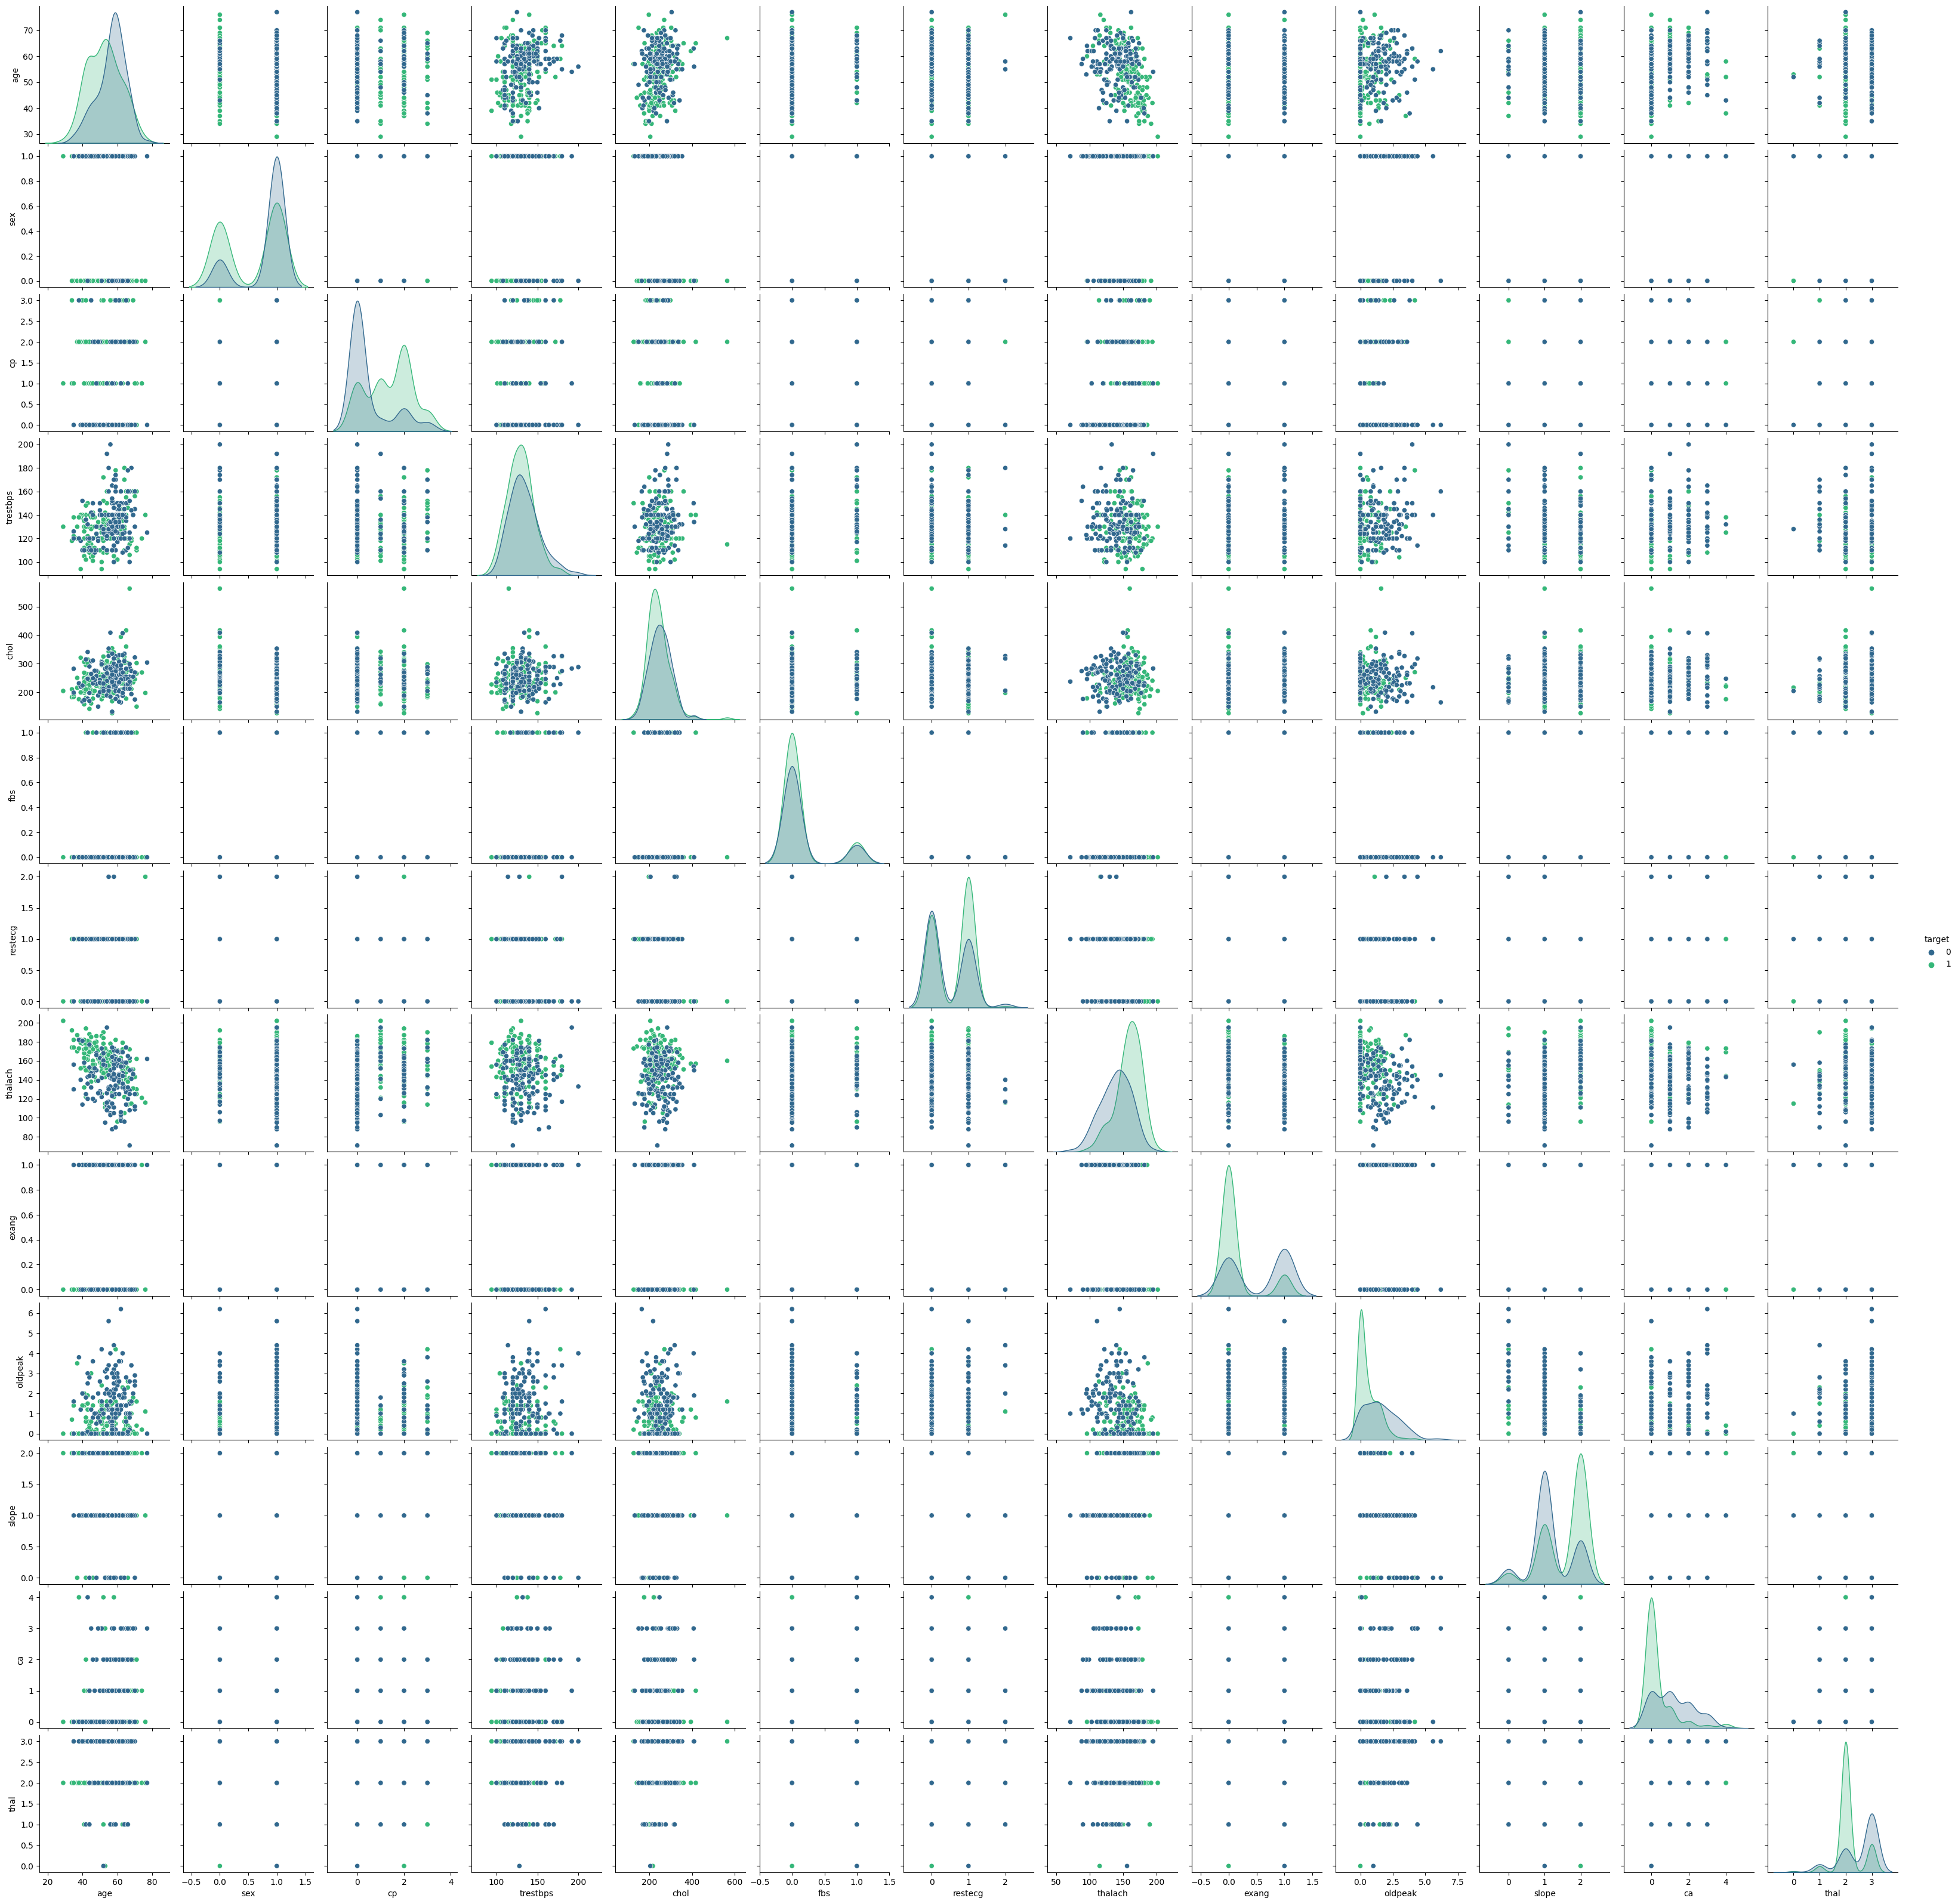

In [4]:
sns.pairplot(df, hue='target', palette='viridis')

plt.show()

<font size="6">The numerical distribution of all columns was plotted using a histogram.</font>

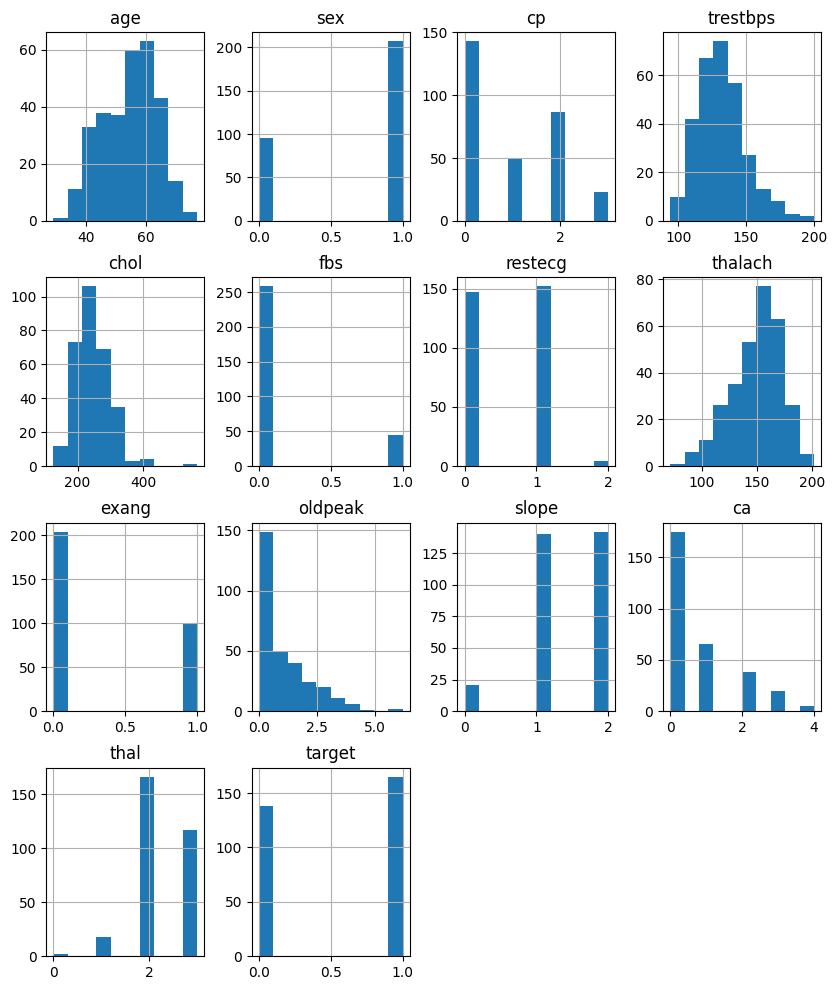

In [5]:
df.hist(figsize=(10,12))
plt.show()

<font size="6">Boxplot was created for all columns except those boolean (0-1) values.</font>

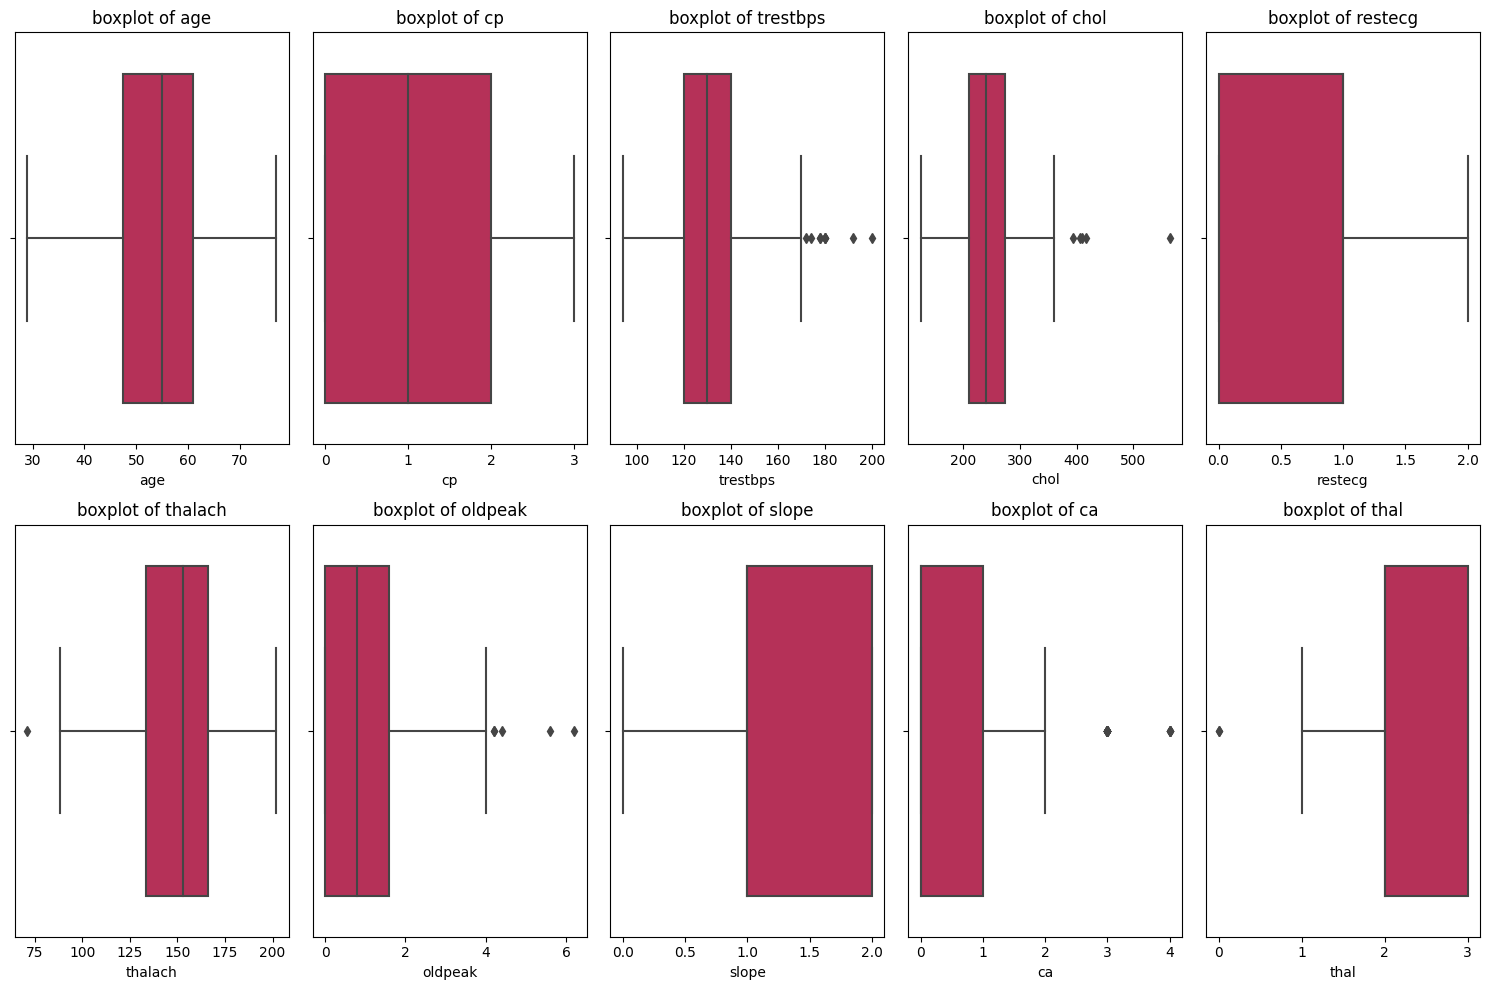

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))


axes = axes.ravel()

for i, col in enumerate(df.columns.drop(['target', 'sex', 'fbs', 'exang'])):
    sns.boxplot(data=df, x=col, ax=axes[i], palette='rocket')
    axes[i].set_title(f'boxplot of {col}')

plt.tight_layout()
plt.show()


<font size="6">Correlation matrix of all columns was generated to analyze their interrelationships.</font>

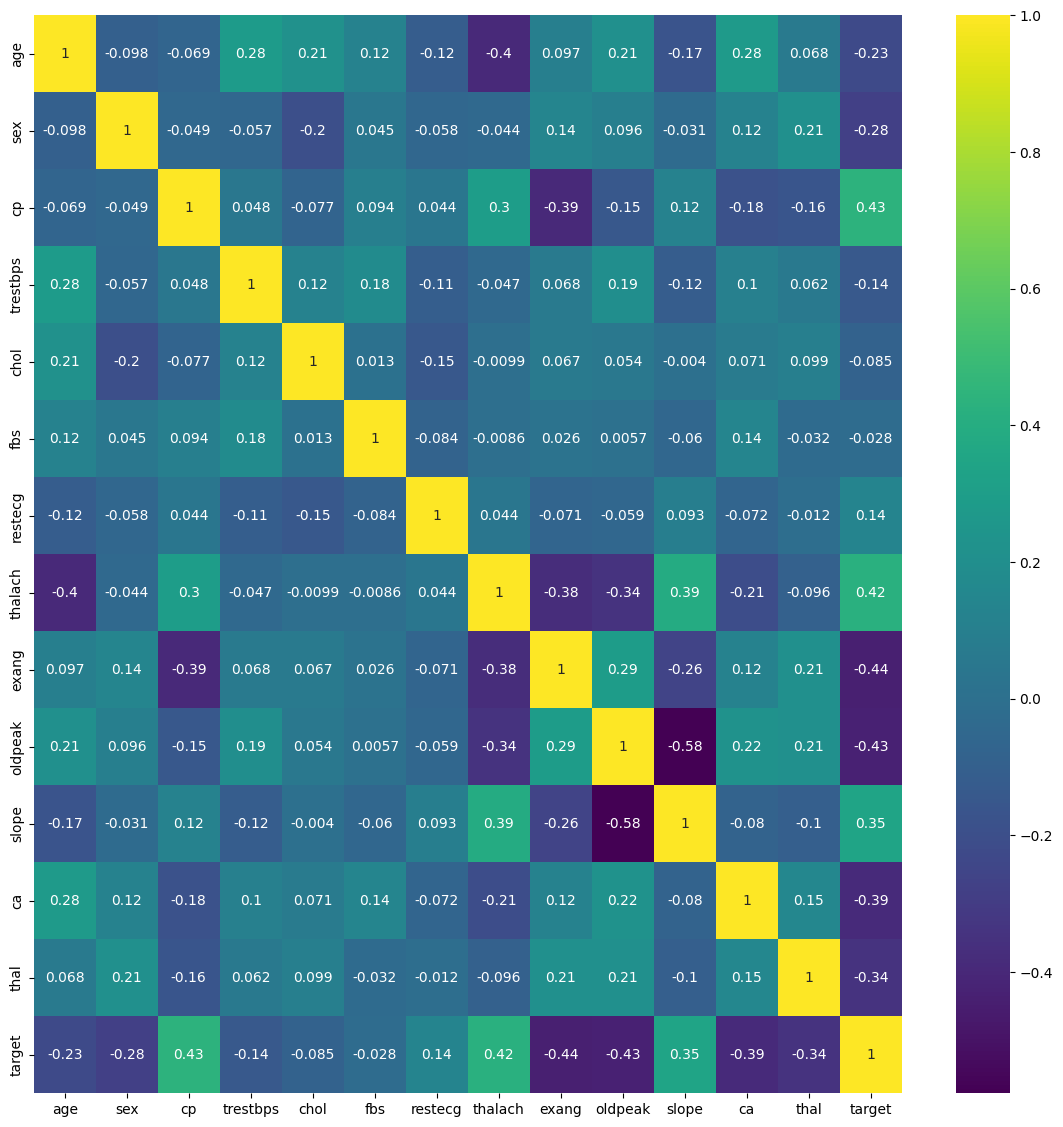

In [7]:
corr = df.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()

<font size="6">Relationship between some values and target was visualized using a boxplot.</font>

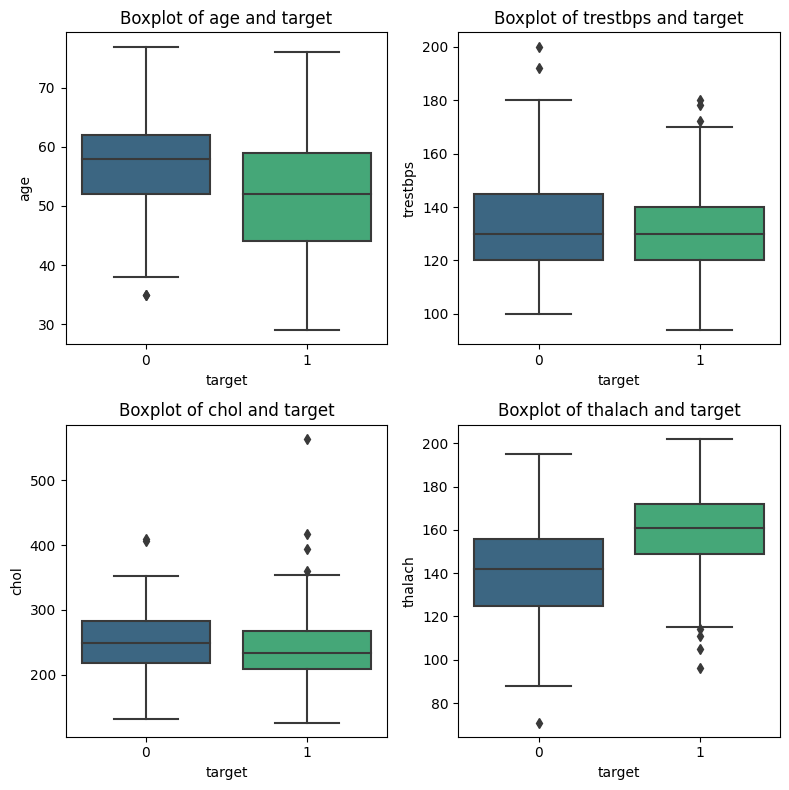

In [8]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='target', y='age', palette='viridis')
plt.title('Boxplot of age and target')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='target', y='trestbps', palette='viridis')
plt.title('Boxplot of trestbps and target')

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='target', y='chol', palette='viridis')
plt.title('Boxplot of chol and target')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='target', y='thalach', palette='viridis')
plt.title('Boxplot of thalach and target')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Boxplot of slope and target')

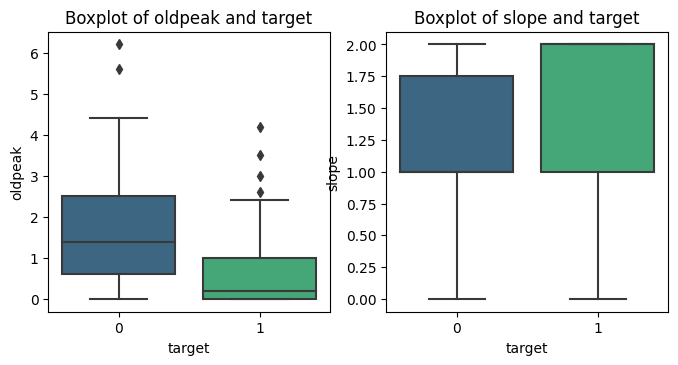

In [9]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='target', y='oldpeak', palette='viridis')
plt.title('Boxplot of oldpeak and target')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='target', y='slope', palette='viridis')
plt.title('Boxplot of slope and target')



# **2- Optimization and Modeling**

<font size="6">First, dataset was split into x and y values (x = all except "target", y = "target"). StandardScaler was used to bring the values closer together for faster results (to x). x and y values were then divided into training and testing sets.</font>

In [10]:
#Train test split
from sklearn.model_selection import train_test_split

x = df.drop('target', axis=1)
y = df['target']

#Standart Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler( )
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=37)

x

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

<font size="6">Using Optuna library, the best parameters and results for XGBoost were found within specified range (param).</font>

In [11]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)

    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))



[I 2024-08-08 23:44:13,718] A new study created in memory with name: no-name-4c5f513b-cf9a-4f68-8b48-f080e87928c3
[I 2024-08-08 23:44:13,785] Trial 0 finished with value: 0.8871080139372822 and parameters: {'lambda': 5.46778147435949e-07, 'alpha': 5.678617598481982e-08, 'max_depth': 7, 'eta': 9.648116401788411e-05, 'gamma': 2.880423583622498e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8871080139372822.
[I 2024-08-08 23:44:13,801] Trial 1 finished with value: 0.8853658536585366 and parameters: {'lambda': 1.213900228944217e-07, 'alpha': 0.32143776707558946, 'max_depth': 3, 'eta': 0.07192368083659506, 'gamma': 0.0008932024507988735, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8871080139372822.
[I 2024-08-08 23:44:13,819] Trial 2 finished with value: 0.9031358885017421 and parameters: {'lambda': 0.03294543623688428, 'alpha': 2.0580607223358857e-06, 'max_depth': 6, 'eta': 0.35459435586409216, 'gamma': 0.0030452847012099557, 'grow_policy': 'depthwise'}. Bes

AUC: 0.9275261324041811
Best hyperparameters: {'lambda': 0.0014143307622647265, 'alpha': 2.388098709963411e-06, 'max_depth': 2, 'eta': 0.6801724134053426, 'gamma': 0.0003095351142855277, 'grow_policy': 'lossguide'}


<font size="6">A new model was created with the best parameters found (for clearer results).</font>

In [12]:
#Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
    'booster': 'gbtree',
    'lambda': trial.params['lambda'],
    'alpha': trial.params['alpha'],
    'max_depth': trial.params['max_depth'],
    'eta': trial.params['eta'],
    'gamma': trial.params['gamma'],
    'grow_policy': trial.params['grow_policy']
}

bst = xgb.train(param, dtrain)
preds = bst.predict(dtest)
pred_labels = np.rint(preds)
accuracy = roc_auc_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))




Accuracy: 92.75%


In [13]:
#report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        35
           1       0.88      0.88      0.88        41

    accuracy                           0.87        76
   macro avg       0.87      0.87      0.87        76
weighted avg       0.87      0.87      0.87        76



## **2.1- Model Visualization**

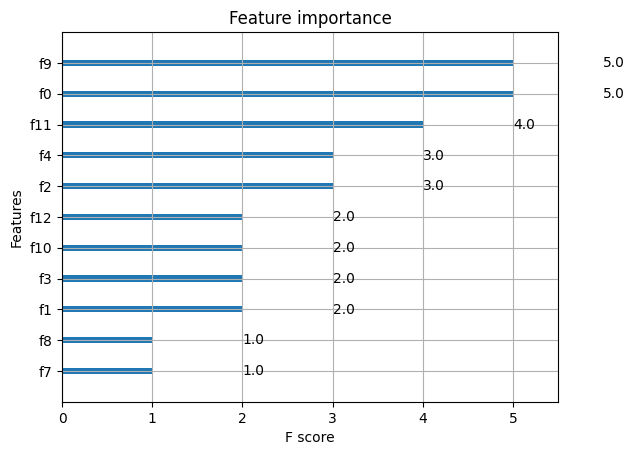

In [14]:
#Feature Visualization
xgb.plot_importance(bst)
plt.show()

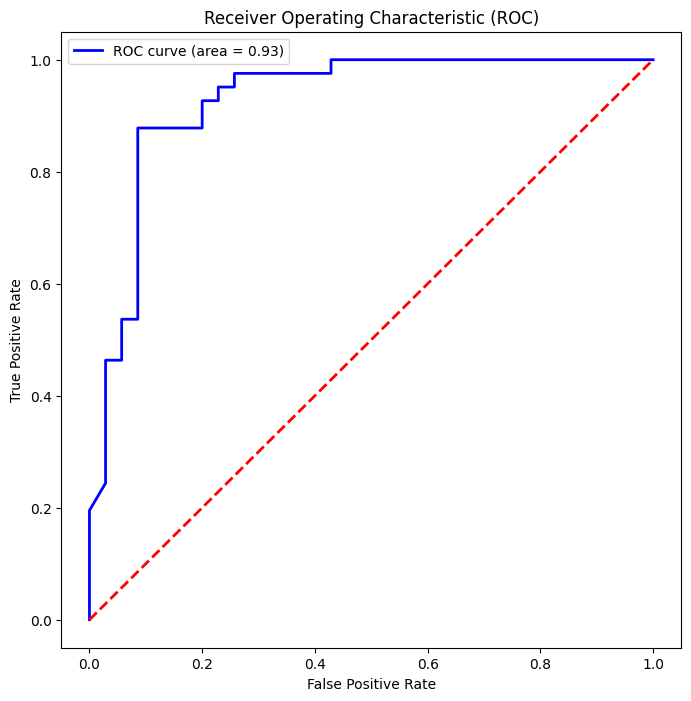

In [15]:
#ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, preds)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % accuracy)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


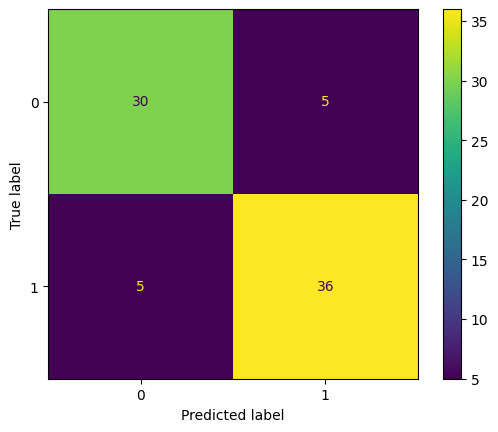

In [16]:
#Confusion Matrix

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()